# Predicting Usage for Capital Bikeshare stations based upon Spatial Characteristics
# Darshan Pandit

# About Me
* ## Transportation Techie @ UMD, College Park
* ## Assistant@ National Center for Smart Growth, UMD
* ## Interested in understanding Decisions and their impact
* ## twitter: @punditD


# Predicting Traffic
* ## Healthier Commute: The new American Dream
    + ### Active Commute : Bike
    + ### Passive Commute : Automated Vehicles
    + ### Cheaper Alternatives : Shared Rides, Carshare
* ## Smarter Transit Systems
* ## Investing for Future

## Downloading Capital Bikeshare Data

[Excellent Utility to merge files](https://bitbucket.org/ArlingtonCounty/bikeshare-trip-history) by Dylan Barlett

```
git clone https://bitbucket.org/ArlingtonCounty/bikeshare-trip-history.git
cd bikeshare-trip-history
wget --input-file=history_urls.txt # Or download file(s) manually
unzip '*.zip'
python merge_csv.py history_merged.csv
```

history_merged.csv will contain the following columns:
* Duration (ms)
* Start time: ISO 8601 format (YYYY-MM-DDTHH:MM:SS)
* Start station
* End time: ISO 8601 format (YYYY-MM-DDTHH:MM:SS)
* End station
* Bike number: may contain odd data (e.g. ? (0x74BEBCE4)). These are errors in the original files.
* Type: 

We manipulate the data to split the time into 5 time periods:
* 12:00am to 7:00am
* 7:00am to 11:00am
* 11:00am to 4:00pm
* 4:00pm to 8:00pm
* 8:00pm to 11:59pm

In addition we also exclude the outlier by filtering [5%,95% of the range]

## Downloading data from OpenStreetmap
OSM has a XAPi-api touch point addition to Overpass api, catered to download data.


In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from time import sleep
from IPython.display import Image, display

ImportError: No module named bs4

In [5]:


queries = { 'bus': '[highway=bus_stop]',
    'bus_2' : '[amenity=bus_station|parking]',
    'education' : '[amenity=college|library|school|university|kindergarten]',
    'railway': '[railway=station]',
    'leisure' : '[amenity=theatre|community_centre|social_centre|gym|townhall]',
    'leisure_2' : '[leisure=common|garden|nature_reserve|park|marina|pitch|playground|swimming_area|swimming_pool|sports_centre|track]',
    'building' : '[building=hotel|stadium|hospital]',
    'building_2' : '[tourism=hotel|hostel|motel]',
    'tourism' : '[tourism=attraction|aquarium|zoo|museum|gallery]',
    'shop' : '[shop=*]' }

bbox= '[bbox=-77.270966,38.775499,-76.795807,39.164141]'

with open('places_temp.csv','a') as places:
    for category,query in queries.items():
        base = 'http://overpass.osm.rambler.ru/cgi/xapi_meta?'
        #base = 'http://www.overpass-api.de/api/xapi?*'
        my_url = base+query+bbox+'[@meta]'
        while True:  
            response = requests.get(my_url)
            if response.status_code==200:
                soup = BeautifulSoup(response.text)
                for n in soup.body.osm:
                    if n.name=='node':
                        places.write(n['id']+','+category+','+n['lat']+','+n['lon']+'\n')
                #print(category)
                break
            else:
                sleep(1000)
                

shop
building
education
leisure
railway
bus


# [Smart Location Database](https://www.epa.gov/smartgrowth/smart-location-mapping)
Using a GIS Intersect, we associate the following attributes from SLD unit to which the Bikeshare station belongs

* ### D1B : Gross population density (people/acre) on unprotected land
* ### D1C : Gross employment density (jobs/acre) on unprotected land
* ### D4b050 : Proportion of CBG employment within ½ mile of fixed-guideway transit stop
* ### D5br : Jobs within 45-minute transit commute,distance decay (walk network travel time, GTFS schedules) weighted per 100000 people
* ### D5be : Working Age Population within 45-minute transit commute,distance decay (walk network travel time, GTFS schedules) weighted per 100000 people
* ### PCT_AO0, PCT_AO1, PCT_AO2P  : Percentage of Households having 0,1,2+ Cars


In [3]:
sld = pd.read_csv('/cousrsework/ENCE 673/data/sld_params.csv')
sld.describe()

,station_id,D1B,D1C,D4b050,D5br,D5be,PCT_AO0,PCT_AO1,PCT_AO2P
count,325.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000
mean,181.618462,24.206780,71.188730,0.644046,0.708883,0.300232,0.275757,0.455135,0.225363
std,105.489141,22.678904,114.153721,0.418834,0.420319,0.165726,0.213188,0.171848,0.171979
min,2.000000,0.005168,0.019957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,9.139543,4.401154,0.134798,0.384859,0.173283,0.114870,0.356140,0.084520
50%,183.000000,17.986252,20.010925,0.866986,0.611289,0.274863,0.236050,0.478650,0.201190
75%,272.000000,32.222019,87.921410,1.000000,0.951316,0.396413,0.393160,0.582715,0.323790
max,371.000000,181.960654,519.938154,1.000000,1.794285,0.965811,0.896860,0.827110,0.846150


In [52]:
#Lets get station bikeshare location info and dump it in a file somewhere
gbfs_status_capital_bikeshare = 'https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json'

response = requests.get(gbfs_status_capital_bikeshare)
response = response.json()

station_map = {}

for r in response['data']['stations']:
    station_map[r['station_id']] = [r['name'],(r['lat'],r['lon'])]
  
#List of co-ordinates for stations
station_cords = [(station[1][0],station[1][1]) for station in station_map.values()]


## Distance Matrix for Stations

In [68]:
def compute_distances(x,station_cords):
    return [vincenty(x,station).miles for station in station_cords]

distance_matrix = {k: compute_distances(v[1],station_cords) for k,v in station_map.items()}
temp = pd.DataFrame.from_dict(distance_matrix, orient='index')
temp.columns = distance_matrix.keys()
distance_matrix = temp
distance_matrix.head()

,111,268,336,396,327,58,66,143,13,56,...,173,207,30,288,444,1,17,101,63,251
111,0.000000,5.825631,2.740551,15.226822,1.138707,2.460723,1.780816,4.698678,1.183359,6.007872,...,15.407357,1.472664,2.398194,4.293029,4.232721,4.373045,3.027252,17.840082,5.812976,1.325984
268,5.825631,0.000000,6.499637,10.270756,6.958107,8.266875,6.890258,9.488359,6.799930,8.527438,...,10.222339,5.743298,3.431705,5.708927,8.067630,8.962874,4.290002,12.730123,5.343578,6.314869
336,3.220335,6.141102,0.766711,13.612078,3.711095,4.638270,2.183640,3.522698,2.869835,2.943085,...,13.981223,1.747723,3.755734,1.370178,7.444812,2.953525,1.852590,16.262718,3.207667,2.107512
396,7.519140,12.884541,6.503180,20.422935,6.645024,5.817963,6.035004,3.566047,6.347223,6.626608,...,20.886370,7.151823,9.705030,8.181520,9.528291,4.144007,8.759210,23.054830,9.889469,6.627105
327,15.226822,10.270756,14.335396,0.000000,16.308837,17.597260,15.472024,16.918300,15.797074,13.998727,...,1.004647,14.413884,13.157382,12.334204,18.281776,16.346073,12.429508,2.650784,10.547906,15.061051


## Compute Place/Station Distance Matrix

In [123]:
places = pd.read_csv('places_temp.csv',names=['pid','ptype','lat','lon'])

#Some sanitization
places.ptype.replace(to_replace='leisure_2',value='leisure',inplace=True)
places.ptype.replace(to_replace='building_2',value='building',inplace=True)
places.ptype.replace(to_replace='bus_2',value='bus',inplace=True)

places.drop_duplicates('pid',keep='last',inplace=True)
places.set_index('pid',inplace=True)
places['dist'] = places.apply(vincenty[places['lat'],places['lon'],station_cords])


,ptype,lat,lon
pid,,,
30066940,leisure,38.884208,-77.003440
30066941,leisure,38.883326,-77.003434
30066942,leisure,38.883325,-77.002146
49133384,leisure,39.033840,-77.122811
49133386,leisure,39.033984,-77.122777


In [ ]:
places_temp = places.sample(n=20)

def wrap_compute(x):
    return compute_distances((x['lat'],x['lon']),station_cords)

temp = places_temp.apply(wrap_compute,axis=1)

temp = temp.apply(pd.Series)
temp.columns = distance_matrix.columns

#Walking Distance Threshold
temp = temp.applymap(lambda x: x if x<0.8 else 0)
temp = temp.div(temp.sum(axis=1), axis=0)

t = t.reset_index(level=0)

t.drop(['pid','lat','lon'], axis=1,inplace=True)
t = t.groupby(t.ptype).sum()
t = t.transpose()
t.rename(columns={'$ptype': 'stationid'},inplace=True)
t.head()

#compute_distances((places_temp.lat,places_temp.lon),station_cords)

# Linear Regression

In [ ]:
start_pivot = pd.pivot_table(df,values=['bike_number'],index=['end_station'],columns=['end_period'],aggfunc='count')
start_pivot = start_pivot.divide(len(df['end_date'].unique()))


start_attribs = pd.read_csv('station_attribs.csv',index_col=[0])
sld_params = pd.read_csv('sld_params.csv',index_col=[0])
start_attribs = pd.merge(start_attribs,sld_params,how='inner',left_index=True,right_index=True)

start_pivot.index=np.asarray(start_pivot.index,dtype='int64')
finaldf = pd.merge(start_pivot,start_attribs,how='inner',left_index=True,right_index=True )


In [ ]:
import statsmodels.api as sm
i=0
for col in finaldf.columns[0:5]:
    Y = finaldf[col]
    X = finaldf.iloc[:,5:]
    X = sm.add_constant(X)
    
    model = sm.OLS(Y,X,missing='drop')
    results = model.fit()
    print("For Time Period : "+str(i))
    i=i+1
    print(results.summary())

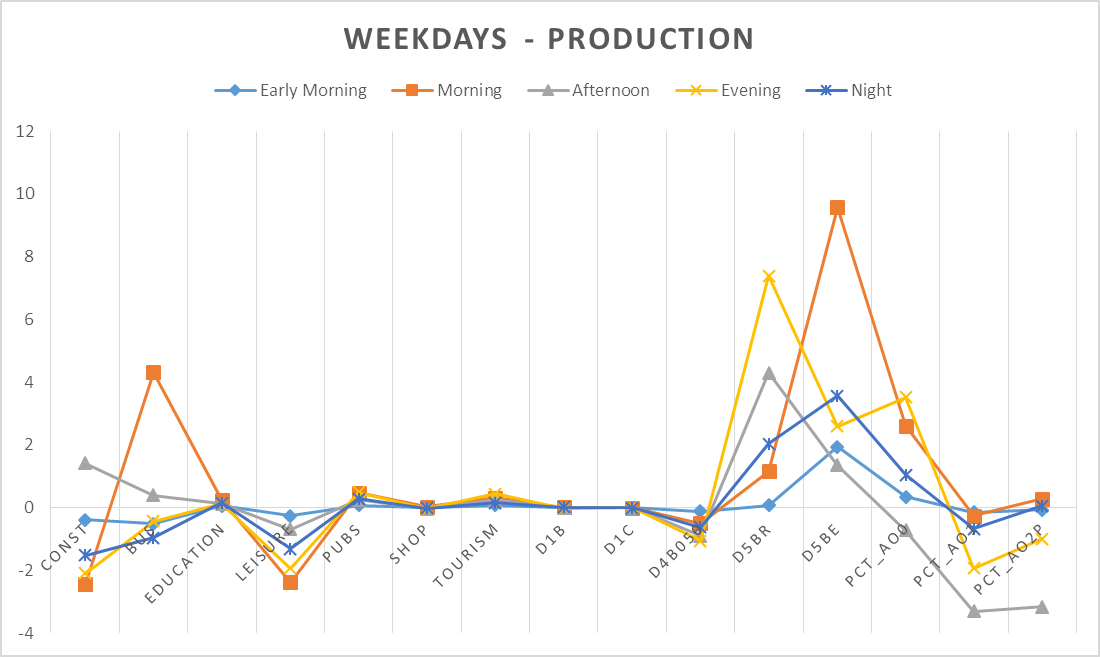

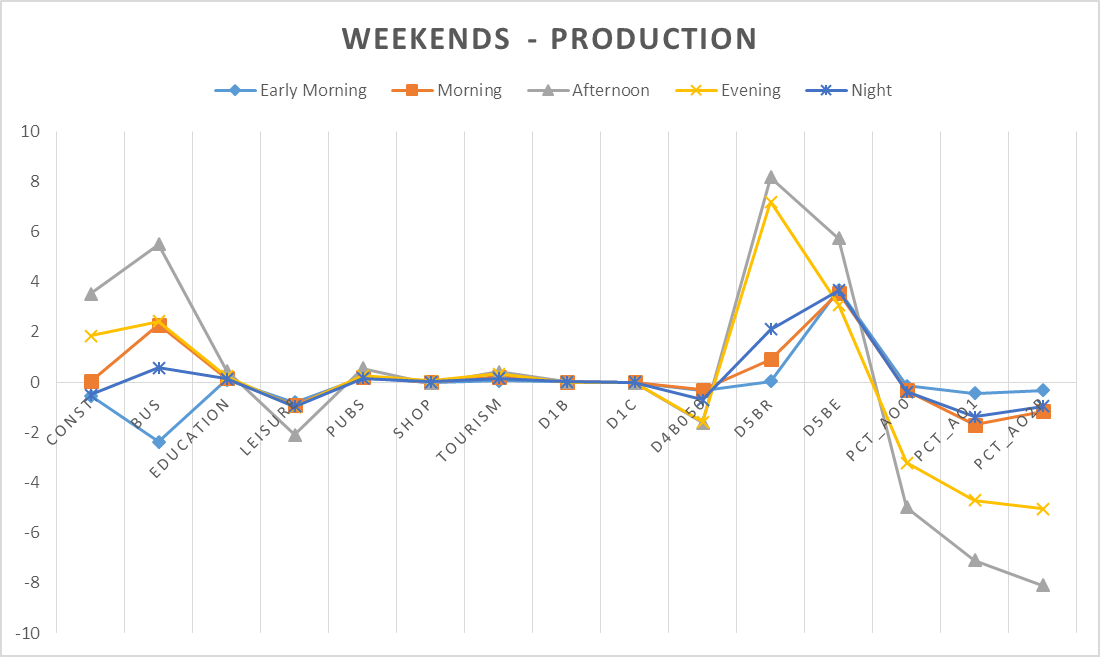

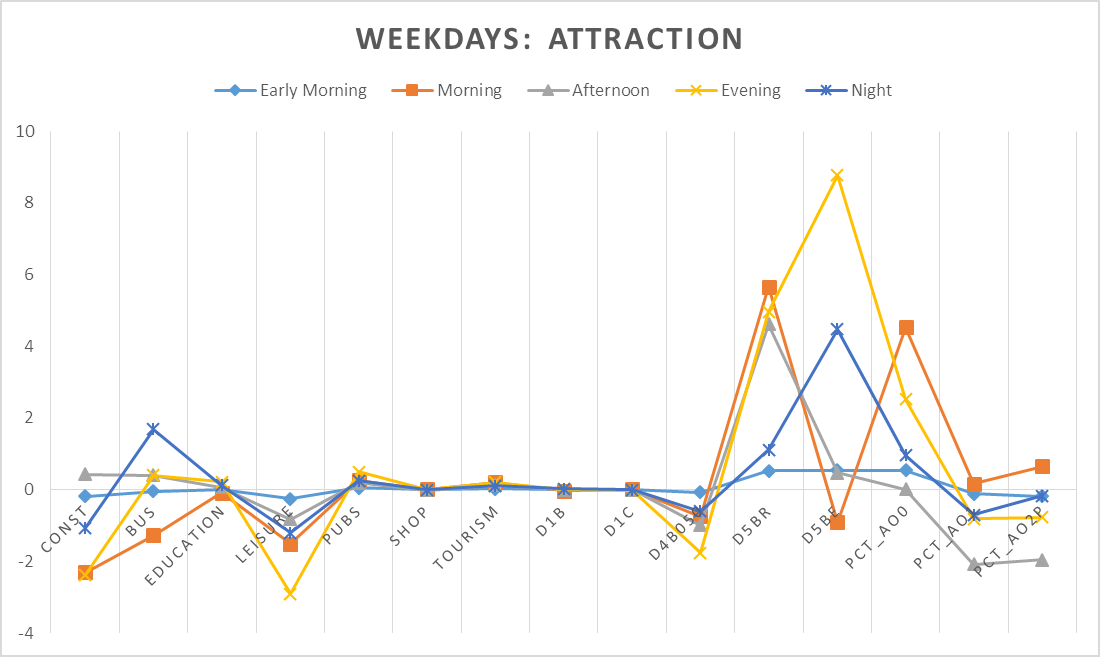

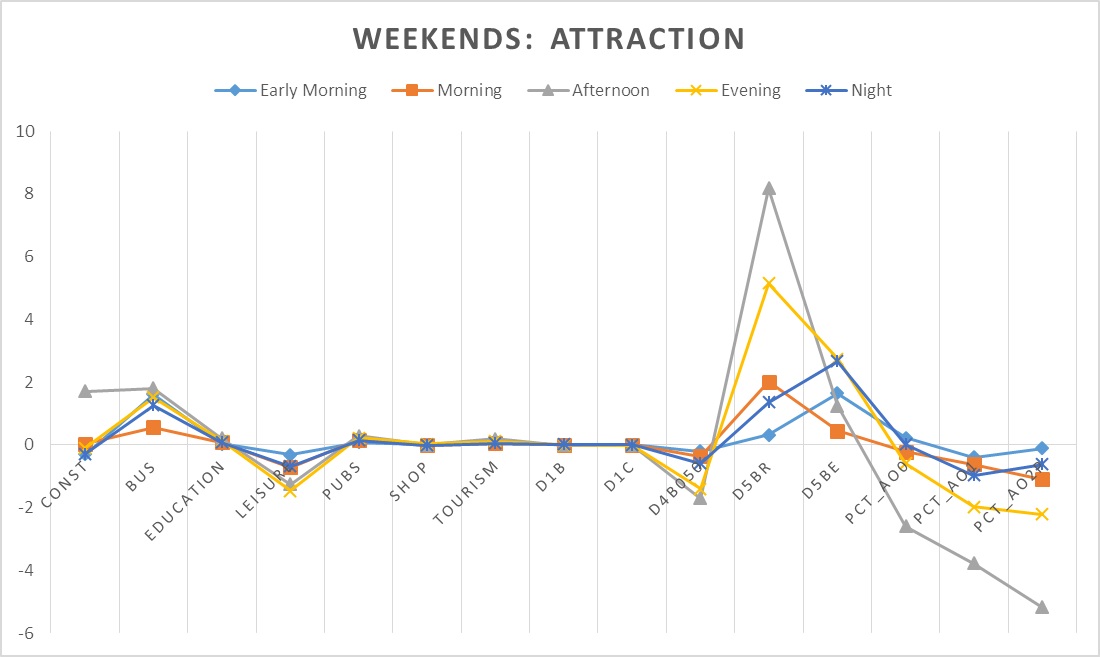

In [9]:
listOfImageNames = ['screenshot001.png','screenshot002.png','screenshot004.png','screenshot005.png',
                    ]

for imageName in listOfImageNames:
    display(Image(filename=imageName))